# Dance music detector

This is the second attempt to train a neural network that would recognize what kind of dance can I dance to a given song. This time I gathered more, better quality data.

In [1]:
import librosa
import librosa.display
import IPython
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import os
from pathlib import Path
import random
import multiprocessing as mp
import random
from pydub import AudioSegment
import warnings
warnings.filterwarnings('ignore')

Those are the playlists that someone, who would like to train their own network, might use. One can use spotdl to download those playlists.

In [20]:
playlists = [
    [
        "ChaCha",
        "https://open.spotify.com/playlist/3QKbcarTgTjfiVp5MziWEo?si=oYrGvKSUSLa12suTXiTWuw",
    ],
    [
        "Salsa",
        "https://open.spotify.com/playlist/16uyZReJ5vQvONxpLEjmvy?si=z4JMOwKkRbexBM4AoalhIw",
    ],
    [
        "Bachata",
        "https://open.spotify.com/playlist/4ptcVAWHT2IxhHsi5DDD4s?si=rv_BrSQKQEWl1ePCjk8zPA",
    ],
    [
        "Rock&Roll",
        "https://open.spotify.com/playlist/4Wf4GCxJfRvKOJbQg4eTfB?si=BiaFgxCxSEGM51V6lUkuQA",
    ],
]
TEMP_DATA_FOLDER = "./temp_data/"
TEST_RATIO = 0.3
MUSIC_PATH = "./data/music"
SPECTROGRAM_PATH = "./data/spectrogram"

# One could download playlists using command: spotdl <playlist_url>

Since I had mp3 files I needed to convert them to .wav format, because librosa works faster with them. Here I also split data into train and test (really a validation) sets.

In [3]:
for s in os.listdir(TEMP_DATA_FOLDER):
    print(s)
    files = [file for file in os.listdir(os.path.join(TEMP_DATA_FOLDER,s)) if file.endswith(".mp3")]
    print(files)
    number_of_test_files = int(len(files)*TEST_RATIO)
    test_files = random.sample(files,number_of_test_files)
    train_files = [f for f in files if f not in test_files]
    os.makedirs(os.path.join(MUSIC_PATH,'test',s), exist_ok=True)
    for test_file in test_files:
        AudioSegment.from_mp3(os.path.join(TEMP_DATA_FOLDER,s,test_file)).export(os.path.join(MUSIC_PATH,'test',s,test_file), format="wav")
    os.makedirs(os.path.join(MUSIC_PATH,'train',s), exist_ok=True)
    for train_file in train_files:
        AudioSegment.from_mp3(os.path.join(TEMP_DATA_FOLDER,s,train_file)).export(os.path.join(MUSIC_PATH,'train',s,train_file), format="wav")
        
        
    

In order to recognize those songs I am going to sample random 100 samples 5s long each. This should be enough to find a rhythm. 
What I have changed from version 1 is that I no longer use plots to generate spectrograms.After collecting more songs I recognized that plots in matplotlib stay in memory after being saved on disc. I have tried many different sollutions (calling garbage collector, clearing figs in matplotlib etc) but none of them worked. Than I found an opinion in the internet that spectograms do not need to be generated with myplotlib, because 'plots are for humans to read' and data for neural nets do not need to look good. Following this persons' suggestion I simply converted decibels from librosa to black and white png images.

In [4]:
SAMPLES_PER_FILE = 100
SAMPLE_DURATION = 5.0

In [5]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def create_random_spectrogram(musicPath, spectrogramPath):
    file_duration = librosa.get_duration(filename=musicPath)
    startTime = random.uniform(20, file_duration - 20 - SAMPLE_DURATION)
    samples, sample_rate = librosa.load(
        musicPath, duration=SAMPLE_DURATION, offset=startTime
    )
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
    img = scale_minmax(S, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0)
    io.imsave(spectrogramPath, img)
    

Than I run spectrogram genearation on all cores, so it would be faster

In [6]:
def generate_spectrogram_for_file(musicPath, spectrogramPathPrefix):
    for i in range(SAMPLES_PER_FILE):
        create_random_spectrogram(musicPath, f"{spectrogramPathPrefix}-{i}.png")


def generate_spetrograms():
    files_to_process = []
    for root, dirs, files in os.walk("./data/music"):
        for file in files:
            musicPath = os.path.join(root, file)
            spectogramPathPrefix = musicPath.replace("/music/", "/spectrogram/")
            os.makedirs(os.path.dirname(spectogramPathPrefix), exist_ok=True)
            files_to_process.append((musicPath, spectogramPathPrefix))
    pool = mp.Pool(mp.cpu_count())
    pool.starmap(generate_spectrogram_for_file, files_to_process)
    pool.terminate()

In [7]:
generate_spetrograms()

Simple checking if pytorch is using GPU

In [8]:
import fastai
from fastai.vision.all import *
import torch
print(torch.cuda.get_device_name(0))

GeForce GTX 1650


Data loading

In [9]:
data = ImageDataLoaders.from_folder("./data/spectrogram", train='train', valid='test', bs=48)

Some sample (not human readable) data:

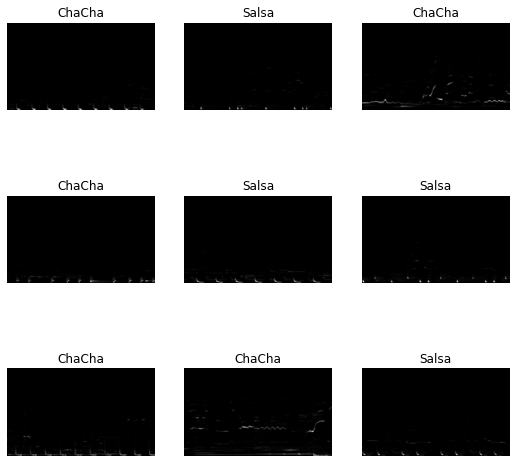

In [10]:
data.show_batch()

I will train my model on resnet34, simply because I saw that other people used it succesfully with spectrgrams.

In [11]:
learn = cnn_learner(data, fastai.vision.models.resnet34, metrics=accuracy)

Lets try what we can get without unfreezing models layers

In [12]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.183410,1.003218,0.655091,00:48
1,0.584366,0.641498,0.795818,00:45
2,0.354686,0.526406,0.845636,00:45
3,0.230911,0.509390,0.863636,00:45
4,0.171763,0.531256,0.870182,00:45


In [13]:
torch.cuda.empty_cache()

Lets see, where are we doing mistakes:

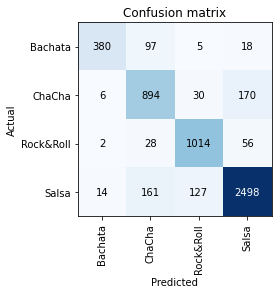

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [15]:
torch.cuda.empty_cache()

Now lets unfreeze a model and find suitable learning rates

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.3182567499825382e-06)

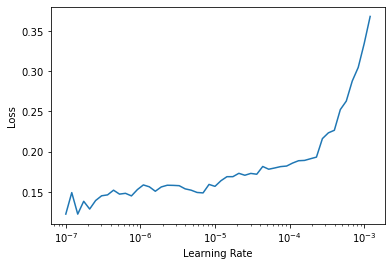

In [16]:
learn.unfreeze()
learn.lr_find()

In [17]:
torch.cuda.empty_cache()

In [18]:
learn.fit_one_cycle(10, max_lr=slice(2.29e-07, 1.58e-06))

epoch,train_loss,valid_loss,accuracy,time
0,0.356072,2.792246,0.593273,01:03
1,0.278037,1.409011,0.659091,01:03
2,0.153560,2.188529,0.604182,01:03
3,0.126565,0.349394,0.866182,01:03
4,0.101098,0.465541,0.861091,01:03
5,0.046592,0.347811,0.903455,01:03
6,0.032432,0.346190,0.930000,01:03
7,0.007098,0.347931,0.943818,01:03
8,0.003786,0.358010,0.953455,01:03
9,0.002560,0.398110,0.952182,01:03


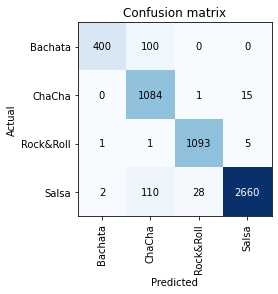

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Conclusions
Clearly getting more data gives better accuracy. There is still some problem with classifying bachata as chacha. Maybe because they are both latino.. I think that it might be due to the fact this class is smaller than others. The surprisingly good score for Salsa might by caused by the fact that there are many songs of the same singers so maybe this neural network has learned to recognize their voices.

In v3 I will try to clear the dataset even more, and maybe add viennese waltz or English waltz.